In [ ]:
# !pip install nam-pytorch
# from nam_pytorch import NAM

In [ ]:
n_hidden_layers = 1 # number of hidden layers
# hidden_dim = 32 # dimensions of hidden layers
l1 = 0.0 # penalty on output
l2 = 0.1 # weights l2 regularization parameter
dropout = 0.025 # dropout parameter [0,1]
batch_size = 128 # batch_size
epochs = 100 # number of epochs
shallow = True

In [ ]:
# machine learning module
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# DNN module
import torch
from torch.nn.parameter import Parameter
from torch import nn, optim                           # torch 에서 제공하는 신경망 기술, 손실함수, 최적화를 할 수 있는 함수들을 불러온다.
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F                       # torch 내의 세부적인 기능을 불러옴.

# Loss
from sklearn.metrics import mean_squared_error        # regression 문제의 모델 성능 측정을 위해서 MSE를 불러온다.

import matplotlib.pyplot as plt

In [ ]:
# Load datset
bos = load_boston()

df = pd.DataFrame(bos.data)       # bos.data: 데이터 불러오기
df.columns = bos.feature_names    # bos.feature_names: 컬럼명 불러오기
df['Price'] = bos.target          # bos.target: 타겟값 불러오기

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
# Data Processing

# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임에서 타겟값(Price)을 제외하고 넘파이 배열로 만들기
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기

# 데이터 스케일링
# sklearn에서 제공하는 MinMaxScaler 
# (X-min(X))/(max(X)-min(X))을 계산
scaler = MinMaxScaler() 
scaler.fit(X) 
X = scaler.transform(X)

scaler.fit(Y)
Y = scaler.transform(Y)

In [ ]:
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
class ExU(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ExU, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight = Parameter(torch.Tensor(out_dim, in_dim))
        self.bias = Parameter(torch.Tensor(in_dim))
        self.reset_parameters()
        
    def reset_parameters(self):
        self.weight = torch.nn.init.normal_(self.weight, mean=3.5, std=0.5)
        self.bias = torch.nn.init.normal_(self.bias, mean=3.5, std=0.5)
        
    def forward(self, inp):
        output = inp-self.bias
        output = output.matmul(torch.exp(self.weight.t()))
#         output = output.matmul(self.weight.t())
        output = F.relu(output)
        
        return output

In [ ]:
class NAM(torch.nn.Module):
    def __init__(self, in_dim, n_hidden_layers, feature_hidden_dim ,dropout = 0, shallow=True):
        super(NAM, self).__init__()
        self.dropout = dropout
        self.model = []
        for i in range(in_dim):
            if n_hidden_layers==0:
                layers = [ExU(1, 1)]
            else:
                layers = [ExU(1, feature_hidden_dim[i]), torch.nn.Dropout(self.dropout)]
                if not shallow:
                    layers+=[torch.nn.Linear(feature_hidden_dim[i], 64), torch.nn.Dropout(self.dropout)]
                    layers+=[torch.nn.Linear(64, 32), torch.nn.Dropout(self.dropout)]
                    layers+=[torch.nn.Linear(32, 1, bias=False)]
                if shallow:
                    layers+=[ExU(feature_hidden_dim[i], 1)]
            self.model.append(torch.nn.Sequential(*layers))
            
        self.model = torch.nn.ModuleList(self.model)

        self.in_dim = in_dim
        self.n_hidden_layers = n_hidden_layers
        self.feature_hidden_dim = feature_hidden_dim
        
        self.summation_params = []
        for i in range(in_dim + 1):
            self.summation_params.append(torch.nn.init.normal_(Parameter(torch.Tensor(1)), mean=0.5, std=0.5))
        self.summation_params = torch.nn.ParameterList(self.summation_params)
            
    def forward(self, x):
        
        output = self.summation_params[0]*self.model[0](x[:,0].reshape(-1,1))
        for i in range(1,self.in_dim):
            output += self.summation_params[i]*self.model[i](x[:,i].reshape(-1,1))
        output += self.summation_params[self.in_dim]
        
#         output = torch.cat([self.summation_params[i]*self.model[i](x[:,i].reshape(-1,1)) for i in range(self.in_dim)], axis=1)
# #         partial_output = output.detach().cpu().numpy()
#         output = output.sum(axis=1)
#         output += self.summation_params[self.in_dim]
    
        return output

In [ ]:
def criterion(outputs, labels, weights, l1=0):
    loss0 = torch.sqrt(torch.mean((labels-outputs)**2))
    loss1 = torch.sqrt(torch.mean(outputs**2))
    
    return loss0+loss1*l1

In [ ]:
def train_nam(model, X_train, Y_train, X_test, Y_test, l1, l2, fold=0, epochs=50, batch_size=128, results_path='./', progress_bar=False):
    
    test_index = list(X_test.index)
    X_val = torch.Tensor(X_train.reset_index(drop=True).iloc[:int(len(X_train)*0.1)].to_numpy())
    Y_val = torch.Tensor(Y_train.reset_index(drop=True).iloc[:int(len(Y_train)*0.1)].to_numpy())
    X_train = torch.Tensor(X_train.reset_index(drop=True).iloc[int(len(X_train)*0.1):].reset_index(drop=True).to_numpy())
    Y_train = torch.Tensor(Y_train.reset_index(drop=True).iloc[int(len(Y_train)*0.1):].reset_index(drop=True).to_numpy())
    X_test = torch.Tensor(X_test.reset_index(drop=True).to_numpy())
    Y_test = torch.Tensor(Y_test.reset_index(drop=True).to_numpy())
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True, num_workers = 4) 
    val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=batch_size) 
    test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=batch_size)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=l2)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2, factor=0.2)
    
    l1=torch.tensor(l1)
    
    m_train_loss = []
    m_val_loss = []
    m_test_loss = []
    min_val_loss = float('inf')
    
    for epoch in range(epochs):
      train_loss = 0
      val_loss = 0
      if progress_bar:
          pbar = tqdm(train_loader)
      else:
          pbar = train_loader
      for data in pbar:
        optimizer.zero_grad()
        outputs = model(data[0].to(device))
        labels = data[1].to(device)
        loss = criterion(outputs, labels, model.parameters(), l1)
        l2 = criterion(outputs, labels, model.parameters())
        loss.backward()
        optimizer.step()
        if progress_bar:
          pbar.set_description('Loss: '+str(l2.detach().cpu().numpy()))
        train_loss += l2.detach().cpu().numpy()/len(train_loader)

      for data in val_loader:
        optimizer.zero_grad()
        outputs = model(data[0].to(device))
        labels = data[1].to(device)
        loss = criterion(outputs, labels, model.parameters())
        val_loss += loss.detach().cpu().numpy()/len(val_loader)
      if val_loss<min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'model.pth')
      lr_scheduler.step(val_loss)
      print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Loss: ', train_loss, '| Validation Loss: ', val_loss)
      m_train_loss.append(train_loss)
      m_val_loss.append(val_loss)

    model.load_state_dict(torch.load('model.pth'))
    test_loss = 0
    true = []
    preds = []
    
    for data in test_loader:
      optimizer.zero_grad()
      outputs = model(data[0].to(device))
      labels = data[1].to(device)
      true += list(labels.detach().cpu().numpy().flatten())
      preds += list(outputs.detach().cpu().numpy().flatten())
      loss = criterion(outputs, labels, model.parameters()).detach().cpu().numpy()
      test_loss += loss/len(test_loader)
    
    print('Test Loss: ', test_loss)
    
    OOF_preds = pd.DataFrame()
    OOF_preds['true_value'] = true
    OOF_preds['preds'] = preds
    OOF_preds['row'] = test_index
    OOF_preds.to_csv(os.path.join(results_path, 'OOF_preds_'+str(fold)+'.csv'), index=False)
    
    return m_train_loss, m_val_loss

In [ ]:
feature_hidden_dim = [min(1000, 2*len(X[X.columns[i]].unique())) for i in range(len(X.columns))]

In [ ]:
model = NAM(len(X.columns), n_hidden_layers, feature_hidden_dim, dropout)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import os
import time
import random
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

In [ ]:
m_train_loss, m_val_loss = train_nam(model, X_train, Y_train, X_test, Y_test, l1, l2, batch_size=batch_size, epochs=epochs)

Epoch:  1/100 | Training Loss:  0.500656247138977 | Validation Loss:  0.5023522973060608
Epoch:  2/100 | Training Loss:  0.4899996419747671 | Validation Loss:  0.4996227025985718
Epoch:  3/100 | Training Loss:  0.4974688192208608 | Validation Loss:  0.49689656496047974
Epoch:  4/100 | Training Loss:  0.4900746842225392 | Validation Loss:  0.4941732585430145
Epoch:  5/100 | Training Loss:  0.48840017120043433 | Validation Loss:  0.49145758152008057
Epoch:  6/100 | Training Loss:  0.4857079784075419 | Validation Loss:  0.4887443780899048
Epoch:  7/100 | Training Loss:  0.4807752271493275 | Validation Loss:  0.48603272438049316
Epoch:  8/100 | Training Loss:  0.4773501952489217 | Validation Loss:  0.4833265244960785
Epoch:  9/100 | Training Loss:  0.47791596253712976 | Validation Loss:  0.48062583804130554
Epoch:  10/100 | Training Loss:  0.47665104269981384 | Validation Loss:  0.47792500257492065
Epoch:  11/100 | Training Loss:  0.47374058763186133 | Validation Loss:  0.4752327501773834


In [ ]:
# files = os.listdir('/content')
# df = pd.concat([pd.read_csv('/content/'+i) for i in files if 'OOF_preds_' in i])
# df.to_csv('OOF_preds.csv')

In [ ]:
# df = pd.read_csv('OOF_preds.csv').drop(columns = ['Unnamed: 0'])
# df = df.sort_values(by = 'row').reset_index(drop = True)
# df['True_pT'] = 1/df['true_value']
# df['Predicted_pT'] = 1/df['preds']

In [ ]:
class NAM(torch.nn.Module):
    def __init__(self, in_dim, n_hidden_layers, feature_hidden_dim ,dropout = 0, shallow=True):
        super(NAM, self).__init__()
        self.dropout = dropout
        self.model = []
        for i in range(in_dim):
            if n_hidden_layers==0:
                layers = [ExU(1, 1)]
            else:
                layers = [ExU(1, feature_hidden_dim[i]), torch.nn.Dropout(self.dropout)]
                if not shallow:
                    layers+=[torch.nn.Linear(feature_hidden_dim[i], 64), torch.nn.Dropout(self.dropout)]
                    layers+=[torch.nn.Linear(64, 32), torch.nn.Dropout(self.dropout)]
                    layers+=[torch.nn.Linear(32, 1, bias=False)]
                if shallow:
                    layers+=[ExU(feature_hidden_dim[i], 1)]
            self.model.append(torch.nn.Sequential(*layers))
            
        self.model = torch.nn.ModuleList(self.model)

        self.in_dim = in_dim
        self.n_hidden_layers = n_hidden_layers
        self.feature_hidden_dim = feature_hidden_dim
        
        self.summation_params = []
        for i in range(in_dim + 1):
            self.summation_params.append(torch.nn.init.normal_(Parameter(torch.Tensor(1)), mean=0.5, std=0.5))
        self.summation_params = torch.nn.ParameterList(self.summation_params)
            
    def forward(self, x):
        
        output = torch.cat([self.summation_params[i]*self.model[i](x[:,i].reshape(-1,1)) for i in range(self.in_dim)], axis=1)
        partial_output = output.detach().cpu().numpy()
        output = output.sum(axis=1)
        output += self.summation_params[self.in_dim]
        
        return output, partial_output

In [ ]:
max_values = df.iloc[:, :-1].max().to_numpy()
min_values = df.iloc[:, :-1].min().to_numpy()

In [ ]:
model = NAM(len(X.columns), n_hidden_layers, feature_hidden_dim, dropout)
model.load_state_dict(torch.load('model.pth'))
input_to_model = torch.Tensor([[ min_values[j]+(max_values[j]-min_values[j])*i/1000 for i in range(1000)] for j in range(len(X.columns))]).t()

In [ ]:
_, partial_output = model(input_to_model)

In [ ]:
partial_output.shape

(1000, 13)

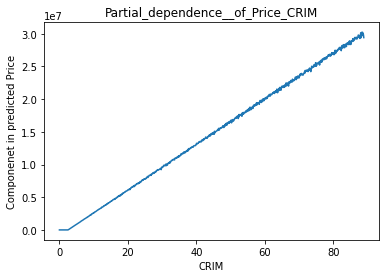

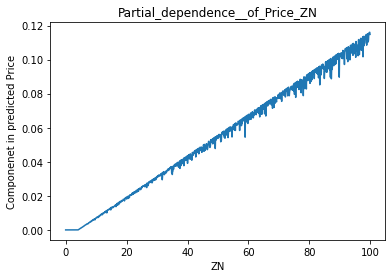

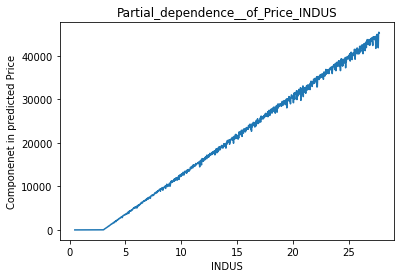

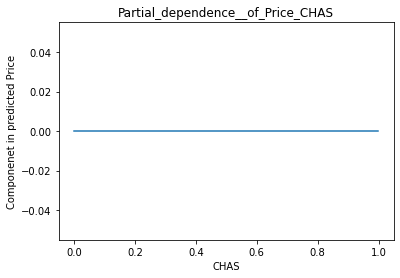

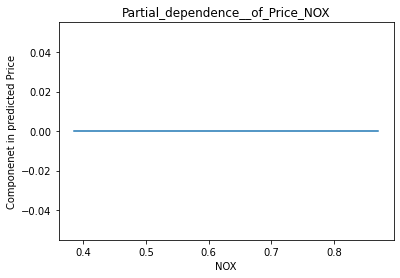

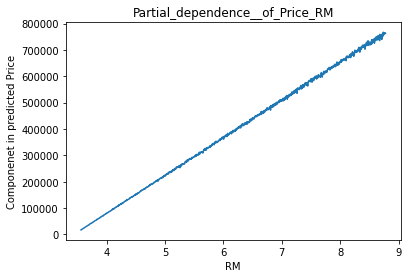

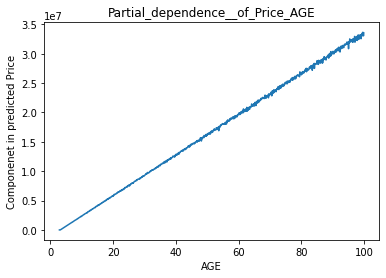

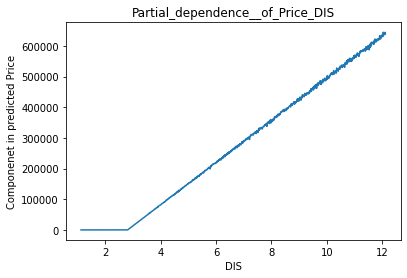

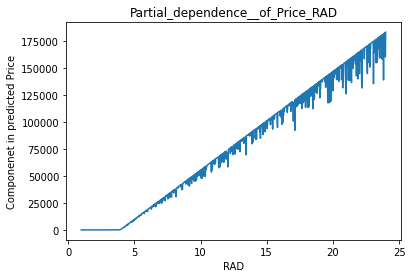

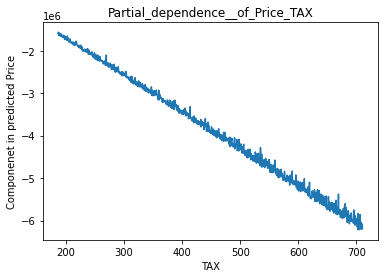

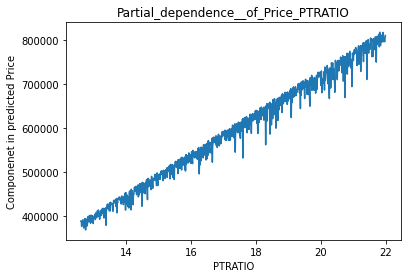

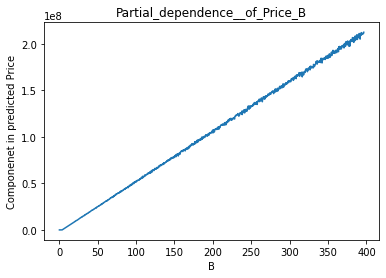

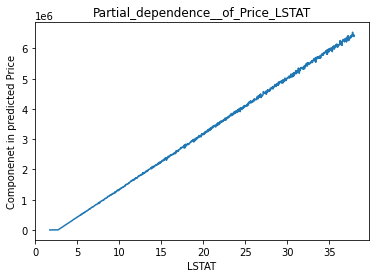

In [ ]:
for i in range(len(X.columns)):
    plt.plot([min_values[i]+(max_values[i]-min_values[i])*j/1000 for j in range(1000)], partial_output[:,i].flatten())
    plt.title('Partial_dependence__of_Price_'+ df.iloc[:, :-1].columns[i])
    plt.xlabel(df.iloc[:, :-1].columns[i])
    plt.ylabel('Componenet in predicted Price')
    plt.show()